In [1]:
import random
import math
import numpy as np
from deap import base
from deap import creator
from deap import tools
from deap import algorithms


In [2]:
# Dimension number (number of the attributes)
DIM_SIZE = 30

In [3]:
# The power function (domain <-100,100>)
MIN_VALUES = -100
MAX_VALUES = 100

def F1(tab):
    return sum([x*x for x in tab]),

In [4]:
# <-10.10>
# MIN_VALUES = -10
# MAX_VALUES = 10
def F2(tab):
    suma = sum([abs(x) for x in tab])
    mul = 1
    for x in tab:
        mul*= abs(x)
    return suma + mul,

In [6]:
# Definition of the Generalized Schwefel Problem 2.26 (F8)(domain <-500, 500>)
#MIN_VALUES = -500
#MAX_VALUES = 500

def F8(tab):
    return sum([ math.sin(math.sqrt(abs(x))) for x in tab]),

In [7]:
#Create type for minimization of the function
creator.create("FitnessMin",base.Fitness,weights=(-1.0,))

#Create type for store food resource (contains extra atribute (trial) 
creator.create("FoodSource", list, fitness=creator.FitnessMin, 
trial = 0)


In [8]:
# Definition of the food source (additional content)
def initFoodSource(size,pmin,pmax):
    foodSource = creator.FoodSource(random.uniform(pmin,pmax) for
_ in range(size))
    foodSource.trial = 0
    return foodSource

In [9]:
#Create toolbox for register needed functions
toolbox = base.Toolbox()

#Register function used for init the food resource
toolbox.register("FoodSource", initFoodSource, size = DIM_SIZE, 
pmin= MIN_VALUES, pmax=MAX_VALUES)

#Register function for create population of food resources
toolbox.register("FoodSources",tools.initRepeat, list, 
toolbox.FoodSource)


In [10]:
#Create type for store bees
creator.create("Bee", list, fitness=creator.FitnessMin)

def initBee(size,pmin,pmax):
    bee = creator.Bee(0 for _ in range(size))
    return bee

In [11]:
#Register function used for init Bee
toolbox.register("Bee", initBee, size = DIM_SIZE, pmin= MIN_VALUES, 
pmax=MAX_VALUES )

#Register function for create population of bees
toolbox.register("Bees",tools.initRepeat, list, toolbox.Bee)

In [12]:
## Function for move the employed bee 
def moveEmployedBees(foodSources,employedBees):
    n = len(employedBees)
    #For each bee (all)
    for fr1Index in range(0,n):
            fr2Index = random.sample([i for i in range(0,n) if
i!=fr1Index],1)[0]
            fr1 = foodSources[fr1Index]
            fr2 = foodSources[fr2Index]
            employedBee = employedBees[fr1Index]
            
            randValues = [random.random() for i in range(len(fr1))]
            newPos = [b1 + r * (b1 - b2) for b1, b2, r in
zip(fr1,fr2,randValues)]
            for i in range(len(employedBee)):
                employedBee[i] = newPos[i]
            del employedBee.fitness.values # need recalculation of the fitness
            fr1.trial = fr1.trial+1 #Increase of using of the food source


In [13]:
# Functions for implementation modified roulette whell selection method
# 1. Get one random food resource based on cumulative probability (roulette whell)
def getOneIndex(piCum):
    randomValue = random.random()
    for index, elem in enumerate(piCum):
        if elem > randomValue:
            return index
# 2. Calculate the probability of selection according to the ABC equations
def calcPi(foodResources):
    fi = [1.0/(1-fs.fitness.values[0]) if
fs.fitness.values[0]>=0.0 else 1.0 + abs(fs.fitness.values[0]) for
fs in foodResources]
    minfi = min(fi)
    finorm = [x + minfi for x in fi]
    sumfi = sum(finorm)
    pi = [x/sumfi for x in finorm]
    return pi

# 3. Define te finall function for create the indexes of the food sources according to propability
def roulette(foodResources,N):
    pi = calcPi(foodResources)
    piCum = np.cumsum(pi)
    indexes = [getOneIndex(piCum) for i in range(0,N)]
    return indexes

In [64]:
## Function for move the onlooker bee (better food resources are using more frequently)
# For the onlooker - bees select food resources based on the probability
def moveOnlookerBees(foodSources,employedBees):
    n = len(employedBees)
    selectedIndexes = roulette(foodSources,n)
    
    #For each bee (selected according to probability P (roulette wheel)
    for fr1Index,fr1IndexBee in zip(selectedIndexes,range(0,n)):
        fr2Index = random.sample([i for i in range(0,n) if
i!=fr1Index],1)[0]
        fr1 = foodSources[fr1Index]
        fr2 = foodSources[fr2Index]
        employedBee = employedBees[fr1IndexBee]
        
        randValues = [random.random() for i in range(len(fr1))]
        newPos = [b1 + r * (b1 - b2) for b1, b2, r in
zip(fr1,fr2,randValues)]
        for i in range(len(employedBee)):
            employedBee[i] = newPos[i]
        del employedBee.fitness.values # need recalculation of the fitness
        fr1.trial = fr1.trial+1 #Increase of using of the food resource


In [65]:
## Function for move the scoutOutBees
## This method check only tial number, if is to big, then restars location of the food resource and number of trials
def moveScotOutBees(foodSources, min_x, max_x, trialNumber):
    for fs in foodSources:
        if fs.trial >= trialNumber:
            fs.values = random.uniform(min_x,max_x)
            fs.trial = 0
            del fs.fitness.values


In [66]:
# Function for update food sources performed by all bees (onlookers and workers)
def updateFoodSources(foodSources,bees,globalBest):
    for foodSource, bee in zip(foodSources,bees):
        if foodSource.fitness.values > bee.fitness.values:
            foodSource.fitness.values = bee.fitness.values
            for i in range(len(foodSource)):
                foodSource[i] = bee[i]
            updateGlobalBest(foodSource,globalBest)

In [67]:
# Function for update global best
def updateGlobalBest(foodSource, globalBest):
    if globalBest.fitness.values > foodSource.fitness.values:
        for i in range(len(globalBest)):
            globalBest[i] = foodSource[i]
        globalBest.fitness.values = foodSource.fitness.values

In [68]:
# Function for evaluate the food sources or bees
def evaluate(foodSources):
    invalidEvaluate = [ind for ind in foodSources if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalidEvaluate)
    for ind, fit in zip(invalidEvaluate, fitnesses):
        ind.fitness.values = fit

In [69]:
# Function for evaluate the food sources 
def evaluateWithUpdateTheGlobalBest(foodSources, globalBest):
    invalidEvaluate = [ind for ind in foodSources if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalidEvaluate)
    for ind, fit in zip(invalidEvaluate, fitnesses):
        ind.fitness.values = fit
        updateGlobalBest(ind,globalBest)


In [70]:
#Register problem
toolbox.register("evaluate",F1)


In [71]:
# Finally the full algorithm introducted by Dervis Karaboga -2005
def ABC_alg(foodSourceNumber,iterationNumber,stats):
    #0. Create the loogbook
    logbook = tools.Logbook()
    g_history = []
    #1. Create the food resources (place for sharing information between bees)
    foodSources = toolbox.FoodSources(n=foodSourceNumber)
    evaluate(foodSources)
    
    #2. Create the EmployedBees
    employedBees = toolbox.Bees(n=foodSourceNumber)
    
    #3. Create the OnlookerBees
    onlookerBees = toolbox.Bees(n=foodSourceNumber)
    
    #4. Create the place for store the best
    globalBest = toolbox.FoodSource()
    globalBest.fitness.values = 50e200,
    
    for gen in range(0,iterationNumber):
        # Employed Bee works
        moveEmployedBees(foodSources,employedBees)
        #Evaluate
        evaluate(employedBees)
        # Save the better solution in the foodSources
        updateFoodSources(foodSources,employedBees,globalBest)
        # Onloker Bee works
        moveOnlookerBees(foodSources,onlookerBees)
        #Evaluate
        evaluate(onlookerBees)
        # Save the better solution in the foodSources 
        updateFoodSources(foodSources,onlookerBees,globalBest)
#ScotOutBees (thats means - restart not efficient food resources -new random value)

        moveScotOutBees(foodSources,MIN_VALUES,MAX_VALUES,2*DIM_SIZE)
    
        #Evaluate the restarted solutions (in this case restarted hard the current solution)
        evaluateWithUpdateTheGlobalBest(foodSources,globalBest)
        
        # Recodr statistics about population 
        record = stats.compile(foodSources)
        logbook.record(gen=gen, evals=foodSourceNumber, **record)
        g_history.append(globalBest.fitness.values)
        
    # return the best solution and logbook
    return g_history, globalBest,logbook
        

In [72]:
# Tests for the algorithm
# The loogs
import numpy
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg",numpy.mean)
stats.register("std",numpy.std)
stats.register("min",numpy.min)
stats.register("max",numpy.max)

In [80]:
# Run the algorithm
g_history, globalBest, logbook = ABC_alg(15,1000,stats)

No handles with labels found to put in legend.


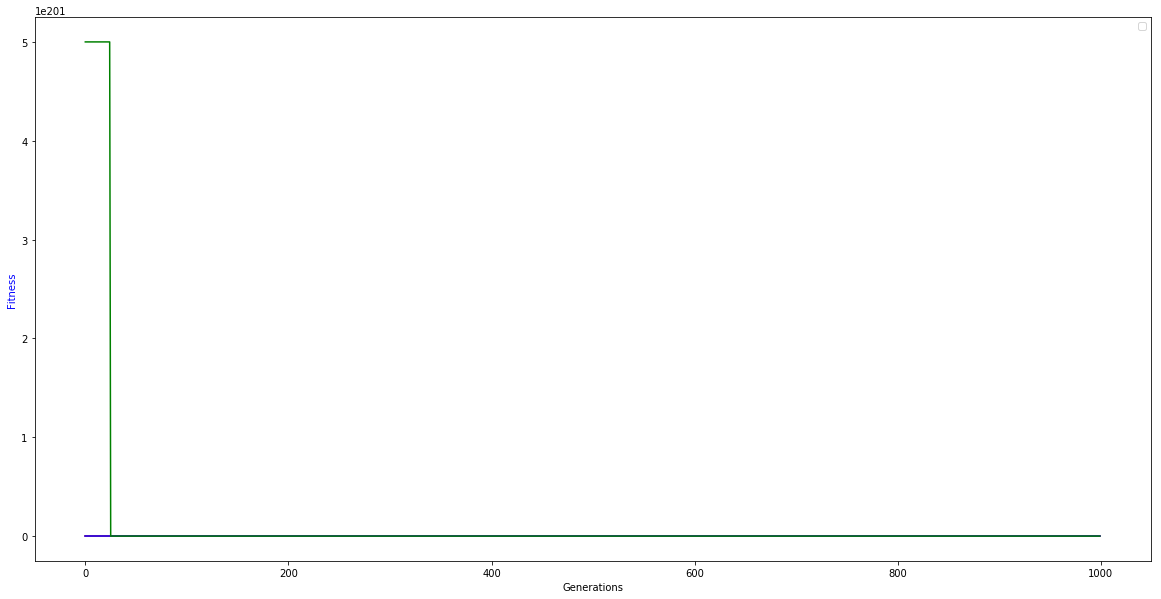

4779.001591403684


In [81]:
# Plot the results
gen, avg, std, Min, Max = logbook.select('gen','avg','std','min','max');
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)
line1 = ax1.plot(gen, Min, "r-")
ax1.legend()
line2 = ax1.plot(gen, avg, "b-")
line3 = ax1.plot(gen, g_history, "g-")

ax1.set_xlabel("Generations")
ax1.set_ylabel("Fitness", color="b")

plt.show()
print(globalBest.fitness.values[0])

In [76]:
'''conclusion: In this algorithm, firstly variable tournament size (TS) is applied 
to select the food source position for onlooker bees which helps
to achieve diversity in solution. 
Then to increase convergence speed, a new solution is
generated in each cycle which replaced the worst one 
it would take more time as the problem size becomes larger 
but it doesn’t take as much time and space as a brute force solution
the abc algorithm would be better than other algotithm .compared with Ga and 


SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-76-eb3b1aa8e7af>, line 6)